In [67]:
import pandas as pd

In [68]:
# Bases de datos de Variables internas y externas

base_ini_interna =  pd.read_csv("base_ini_interna.csv", header=0)
base_ini_externa =  pd.read_csv("base_ini_externa.txt", sep=" ", header=0)


In [69]:
# Bases de datos de inversión

base_ini_parte1 =  pd.read_csv("base_ini_parte1.csv", header=0)
base_inversion =  pd.read_csv("base_inversion.txt", sep=" ", header=0)


In [70]:
# Bases de datos de comportamientos
base_comportamiento =  pd.read_csv("base_comportamiento_2.txt", sep=" ", header=0)
base_comportamiento_3 =  pd.read_csv("base_comportamiento_3.csv", header=0)

bd_inicio_parte1 =  pd.read_csv("bd_inicio_parte1.txt", sep=" ", header=0)


In [71]:
# Merge user interna y externa
user_base = base_ini_interna.merge(base_ini_externa, how="left", right_on="_id_", left_on="_id_")

In [72]:
# Merge inversion
user_base = user_base.merge(base_ini_parte1, how="left",  right_on="_id_", left_on="_id_")
user_base = user_base.merge(base_inversion, how="left",  right_on="_id2_", left_on="_id2_")

In [73]:
# Usuarios en tiempo de aparicion 
tiemp_user = user_base.merge(base_comportamiento, how="right", left_on="_id_", right_on="num_caso")

In [74]:
# Usuarios en comportamiento  
comp_user = user_base.merge(base_comportamiento_3, how="right", left_on="_id_", right_on="num_caso")

Para poder entregar un prestamo seria bueno meter las caracteristicas del credito como un input para seleccionar que tipo de modelo/condiciones usar.
- Si el credito es de una gran cantidad y alto riesgo, utilizaremos un rango de tiempo más amplio(12-18 meses) en el comportamiento del cliente
- Si el credito es de una cantidad menor, por lo que implica bajo riesgo no será necesario usar un rango tan amplio de tiempo, por lo que 6 meses seran suficientes para poder tomar una decisión respecto al credito

Como la información proporcionada no tiene la información hasta el mes actual, 
aumentaremos 6 meses en el rango para poder obtener informacion

In [75]:
# analisis para credito pequeño (ultimos 6 meses) y grande (12 meses)
from datetime import datetime, timedelta

comp_user["mes_informacion"] = pd.to_datetime(comp_user["mes_informacion"])
comp_user["mes"] = comp_user["mes_informacion"].dt.month
comp_user["anho"] =  comp_user["mes_informacion"].dt.year

current_date = datetime.now()
SIX_MONTHS = 6
ONE_YEAR = 12

# comp_user = comp_user[comp_user["anho"] <= current_date.year - 1]
comp_user_6_m = comp_user[(comp_user["mes_informacion"] >= current_date - timedelta(weeks=52)) & 
                          (comp_user["mes_informacion"] < current_date)]

comp_user_12_m = comp_user[(comp_user["mes_informacion"] >= current_date - timedelta(weeks=78)) & 
                          (comp_user["mes_informacion"] < current_date)]

<AxesSubplot:>

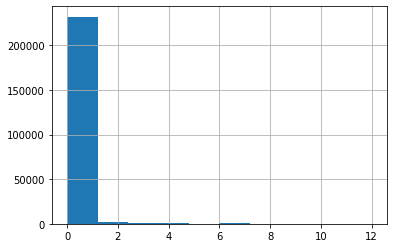

In [76]:
comp_user_6_m["comportamiento_j"].hist()

Del Histograma anterior se observa que no muchos clientes llegan a tener pagos retrasados, por lo que se puede asumir que una
gran cantidad de clientes pueden ser buenos prospectos.

<AxesSubplot:>

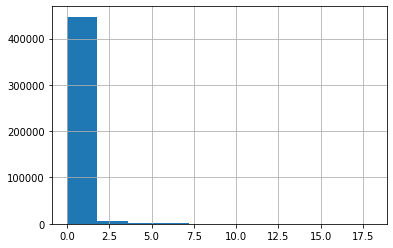

In [77]:
comp_user_12_m["comportamiento_j"].hist()

Para los creditos de riesgo mas alto tambien se observa que la muestra tiene pocos clientes con cartera vencida,
independiente de esto podriamos decir que actualmente el banco tiene a buenos prospectos como clientes.

A contiuación de ambos datasets se filtran aquellos clientes con un comportamiento no deseado

In [78]:
# analisis para credito pequeño (ultimos 6 meses) 

filter_6 = comp_user_6_m.groupby(by=["_id_"], as_index=False).agg({"comportamiento_j": "mean"})
clients_filter_6 = filter_6[filter_6["comportamiento_j"] < 5]
clients_filter_6.columns = ["_id_", "comportamiento_j_avg"]

In [79]:
# analisis para credito pequeño (ultimos 12 meses) 

filter_12 = comp_user_12_m.groupby(by=["_id_"], as_index=False).agg({"comportamiento_j": "mean"})
clients_filter_12 = filter_12[filter_12["comportamiento_j"] < 9]
clients_filter_12.columns = ["_id_", "comportamiento_j_avg"]

De estos dos datasets podemos filtrar en la base de datos `comp_user_6_m` y `comp_user_12_m` que contiene toda la información: base de datos interna, externa e inversion

In [80]:
clients_6_month_analysis = comp_user_6_m.merge(clients_filter_6, how="right", left_on="_id_", right_on="_id_")
clients_12_month_analysis = comp_user_12_m.merge(clients_filter_12, how="right", left_on="_id_", right_on="_id_")

Despues de este analisis podemos seguir filtrando en funcion de las variables de inversion, si el prospecto tiene
componentes externos que demuestren que tiene otro credito, si internamente cuenta con saldo en su cuenta.

Las variables categoricas por ahora podrian ser removidas hasta determinar si son utiles, en todo caso se podria hacer un encoder para poder asignarles un valor númerico.

La base de datos también contiene valores N/A para alguna filas, de manera "fácil" podriamos remover esas columnas 
pero eliminar datos de un dataframe no es del todo idea y mucho menos si nuestro conjunto es muy pequeño, lo estariamos reduciendo aun más. Por lo que seria recomendable hacer una imputación de los datos aunque esta sea muy basica como el valor promedio de la columna.


In [81]:
from sklearn.impute import SimpleImputer

cols_with_missing = [col for col in clients_6_month_analysis.columns
                     if clients_6_month_analysis[col].isnull().any()]

imputer = SimpleImputer(strategy='median')
dataset_imputed = pd.DataFrame(imputer.fit_transform(clients_6_month_analysis[cols_with_missing]))

dataset_imputed.columns = cols_with_missing

dataset_imputed.drop(cols_with_missing, axis=1, inplace=True)
clients_6_month_analysis = pd.concat([clients_6_month_analysis, dataset_imputed], axis=1)


In [82]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = ["comp_interno2"]
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

oh_dataset = pd.DataFrame(oh_encoder.fit_transform(clients_6_month_analysis[cat_cols]))
oh_dataset.index = clients_6_month_analysis.index
oh_dataset.columns = oh_encoder.get_feature_names(cat_cols)

clients_6_month_analysis.drop(cat_cols, axis=1, inplace=True)
clients_6_month_analysis = pd.concat([clients_6_month_analysis, oh_dataset], axis=1)


En las dos celdas anteriores se hizo imputación para aquellas columnas con valores vacios y para la columna con valor categorico se le aplico un encoder para poder obtener un valor numerico.
De tal manera el dataset ya no cuenta con valores vacios o categoricos.
